# 1. Image Classification with the MNIST Dataset

In this section we will do the "Hello World" of deep learning: training a deep learning model to correctly classify hand-written digits.

## 1.1 Objectives

* Understand how deep learning can solve problems traditional programming methods cannot
* Learn about the [MNIST handwritten digits dataset](http://yann.lecun.com/exdb/mnist/)
* Use the [torchvision](https://pytorch.org/vision/stable/index.html) to load the MNIST dataset and prepare it for training
* Create a simple neural network to perform image classification
* Train the neural network using the prepped MNIST dataset
* Observe the performance of the trained neural network

Let's begin by loading the libraries used in this notebook:

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import torchvision.datasets as datasets

import matplotlib.pyplot as plt

In [3]:
print(torch.__version__)

2.2.2+cu118


In PyTorch, we can use our GPU in our operations by setting the [device](https://pytorch.org/docs/stable/tensor_attributes.html#torch.device) to `cuda`. The function `torch.cuda.is_available()` will confirm PyTorch can recognize the GPU.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [5]:
device

device(type='cuda')

In [ ]:
print(torch.cuda.current_device())          # 현재 사용 중인 GPU ID
print(torch.cuda.device(0))                 # 첫 번째 GPU 정보
print(torch.cuda.get_device_name(0))        # 첫 번째 GPU의 이름

0
NVIDIA GeForce GTX 1080


### 1.1.1 The Problem: Image Classification

In traditional programming, the programmer is able to articulate rules and conditions in their code that their program can then use to act in the correct way. This approach continues to work exceptionally well for a huge variety of problems.

Image classification, which asks a program to correctly classify an image it has never seen before into its correct class, is near impossible to solve with traditional programming techniques. How could a programmer possibly define the rules and conditions to correctly classify a huge variety of images, especially taking into account images that they have never seen?

### 1.1.2 The Solution: Deep Learning

Deep learning excels at pattern recognition by trial and error. By training a deep neural network with sufficient data, and providing the network with feedback on its performance via training, the network can identify, though a huge amount of iteration, its own set of conditions by which it can act in the correct way.

## 1.2 The MNIST Dataset

In the history of deep learning, the accurate image classification of the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), a collection of 70,000 grayscale images of handwritten digits from 0 to 9, was a major development. While today the problem is considered trivial, doing image classification with MNIST has become a kind of "Hello World" for deep learning.

Here are 40 of the images included in the MNIST dataset:

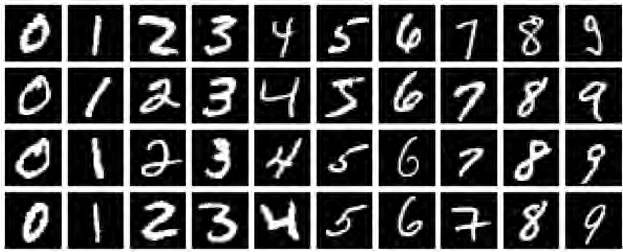

### 1.2.1 Training and Validation Data and Labels

When working with images for deep learning, we need both the images themselves, usually denoted as `X`, and also, correct [labels](https://developers.google.com/machine-learning/glossary#label) for these images, usually denoted as `Y`. Furthermore, we need `X` and `Y` values both for *training* the model, and then, a separate set of `X` and `Y` values for *validating* the performance of the model after it has been trained.

We can imagine these `X` and `Y` pairs as a set of flash cards. A student can train with one set of flashcards, and to validate the student learned the correct concepts, a teacher might quiz the student with a different set of flash cards.

Therefore, we need 4 segments of data for the MNIST dataset:

1. `x_train`: Images used for training the neural network
2. `y_train`: Correct labels for the `x_train` images, used to evaluate the model's predictions during training
3. `x_valid`: Images set aside for validating the performance of the model after it has been trained
4. `y_valid`: Correct labels for the `x_valid` images, used to evaluate the model's predictions after it has been trained

The process of preparing data for analysis is called [Data Engineering](https://medium.com/@rchang/a-beginners-guide-to-data-engineering-part-i-4227c5c457d7). To learn more about the differences between training data and validation data (as well as test data), check out [this article](https://machinelearningmastery.com/difference-test-validation-datasets/) by Jason Brownlee.

### 1.2.2 Loading the Data Into Memory (with PyTorch)

There are many [deep learning frameworks](https://developer.nvidia.com/deep-learning-frameworks), each with their own merits. In this workshop we will be working with [PyTorch 2](https://pytorch.org/get-started/pytorch-2.0/), and specifically with the [Sequential API](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). The Sequential API has many useful built in functions designed for constructing neural networks. It is also a legitimate choice for deep learning in a professional setting due to its [readability](https://blog.pragmaticengineer.com/readable-code/) and efficiency, though it is not alone in this regard, and it is worth investigating a variety of frameworks when beginning a deep learning project.

We will also use the [TorchVision](https://pytorch.org/vision/stable/index.html) library. One of the many helpful features that it provides are modules containing helper methods for [many common datasets](https://pytorch.org/vision/main/datasets.html), including MNIST.

We will begin by loading both the `train` and `valid` datasets for [MNIST](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST).

In [6]:
# Update ToTensor to the recommended v2 version
transform = transforms.ToTensor()

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(train_set, batch_size=32, shuffle=False)

images, _ = next(iter(loader))
print(f"MNIST Mean: {images.mean():.4f}, Std: {images.std():.4f}")
# Expected output: MNIST Mean: 0.1307, Std: 0.3081

f:\Anaconda3\envs\torch_env_113\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


MNIST Mean: 0.1252, Std: 0.3017


In [9]:
# Train set → 데이터 다양성을 늘리기 위해 data augmentation 포함
# 예: 회전, 이동, 크기 변경, 색 변화(컬러 데이터일 경우)

# Validation/Test set → 모델 성능을 평가하는 데이터이므로 augmentation은 하지 않음
# 다만, 모델 입력 크기나 타입을 맞추기 위해 필수 전처리(transform)는 동일하게 적용

# Train용 transform (augmentation 포함 가능)
train_transform = transforms.Compose([
    transforms.RandomRotation(10),   # ±10도 회전
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST 평균/표준편차
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),  # (0~255) → (0.0~1.0)
    transforms.Normalize(mean=[0.1307], std=[0.3081])  # 평균 0, 분산 1로 정규화
])

f:\Anaconda3\envs\torch_env_113\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
train_set = datasets.MNIST("./data/", train=True, download=True, transform=train_transform, shuffle=True)
valid_set = datasets.MNIST("./data/", train=False, download=True, transform=valid_transform)

We stated above that the MNIST dataset contained 70,000 grayscale images of handwritten digits. By executing the following cells, we can see that TorchVision has partitioned 60,000 of these [PIL Images](https://pillow.readthedocs.io/en/stable/reference/Image.html) for training, and 10,000 for validation (after training).

In [122]:
train_set, train_set.data.size(), type(train_set)

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data/
     Split: Train
     StandardTransform
 Transform: Compose(
                  RandomRotation(degrees=[-10.0, 10.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
                  ToTensor()
                  Normalize(mean=[0.1307], std=[0.3081], inplace=False)
            ),
 torch.Size([60000, 28, 28]),
 torchvision.datasets.mnist.MNIST)

In [12]:
train_set.data.shape

torch.Size([60000, 28, 28])

In [13]:
valid_set, valid_set.data.size(), type(train_set)

(Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data/
     Split: Test
     StandardTransform
 Transform: Compose(
                  ToTensor()
                  Normalize(mean=[0.1307], std=[0.3081], inplace=False)
            ),
 torch.Size([10000, 28, 28]),
 torchvision.datasets.mnist.MNIST)

In [14]:
valid_set.data.shape

torch.Size([10000, 28, 28])

*Note*: The `Split` for `valid_set` is stated as `Test`, but we will be using the data for validation in our hands-on exercises. To learn more about the difference between `Train`, `Valid`, and `Test` datasets, please view [this article](https://kili-technology.com/training-data/training-validation-and-test-sets-how-to-split-machine-learning-data) by Kili.

### 1.2.3 Exploring the MNIST Data

Let's take the first x, y pair from `train_set` and review the data structures:

In [15]:
train_set[0]

(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.424

In [16]:
x_0, y_0 = train_set[0]

In [17]:
x_0.shape, type(y_0)

(torch.Size([1, 28, 28]), int)

In [18]:
y_0

5

In [19]:
type(y_0)

int

In [20]:
for x, y in train_set:
    print(x.shape, type(y))
    break

torch.Size([1, 28, 28]) <class 'int'>


In [21]:
train_set.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [22]:
import numpy as np
np.unique(train_set.targets)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [23]:
x_0.shape, x_0.squeeze().shape

(torch.Size([1, 28, 28]), torch.Size([28, 28]))

In [24]:
x_0_sq = x_0.squeeze()
x_0_sq.shape

torch.Size([28, 28])

In [25]:
x_0_sq.unsqueeze(0).shape

torch.Size([1, 28, 28])

In [ ]:
x_0_sq.unsqueeze(1).shape

torch.Size([28, 1, 28])

In [ ]:
x_0_sq.unsqueeze(2).shape

torch.Size([28, 28, 1])

In [ ]:
y_0

5

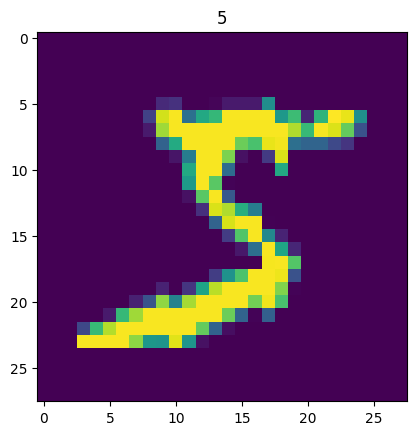

In [26]:
plt.title(y_0)
plt.imshow(x_0.squeeze())  # x_0
plt.show()

Is this a 5 or a poorly written 3? We can view the corresponding label to be sure.

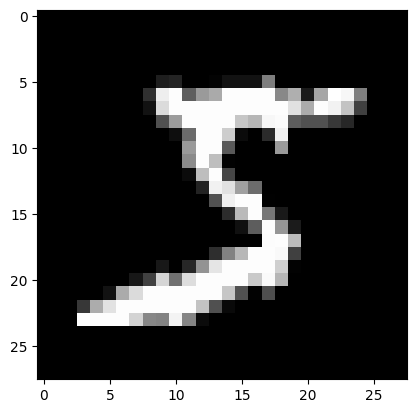

In [27]:
type(x_0)
plt.imshow(x_0.squeeze(), cmap='gray')
plt.show()

In [ ]:
type(x_0.squeeze()), type(x_0.squeeze().numpy())

(torch.Tensor, numpy.ndarray)

In [28]:
def imshow(imgTensor):
    plt.imshow(imgTensor.squeeze())
    plt.show()

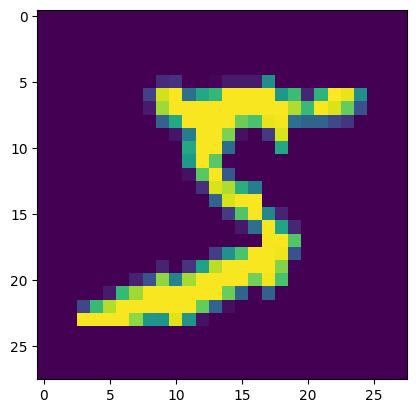

In [29]:
imshow(x_0)

In [30]:
train_set.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

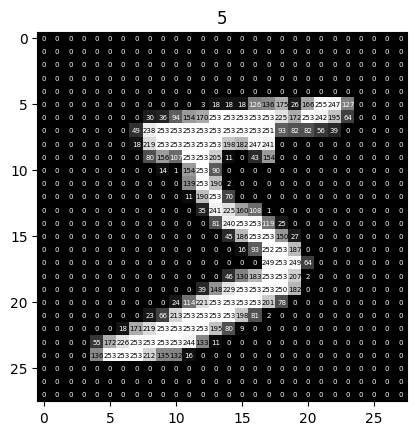

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.imshow(train_set.data[0], cmap='gray')

for i in range(train_set.data[0].shape[0]):
    for j in range(train_set.data[0].shape[1]):
        c = 1 if train_set.data[0][i, j].item() < 128 else 0
        ax.text(j, i, str(train_set.data[0][i, j].item()), color=(c, c, c), ha='center', va='center',fontsize=5)

plt.title('%i' % train_set.targets[0])
plt.show()

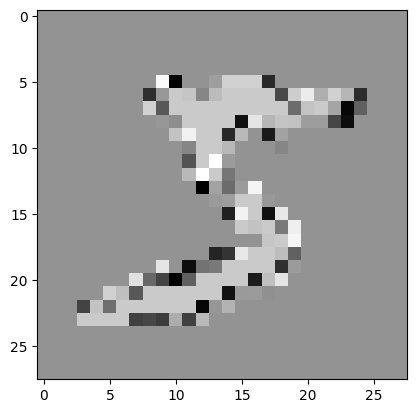

In [32]:
# PIL : pillow image
image = F.to_pil_image(x_0)
plt.imshow(image, cmap='gray')

## 1.3 Tensors

If a vector is a 1-dimensional array, and a matrix is a 2-dimensional array, a tensor is an n-dimensional array representing any number of dimensions. Most modern neural network frameworks are powerful tensor processing tools.

One example of a 3-dimensional tensor could be pixels on a computer screen. The different dimensions would be width, height, and color channel. Video games use matrix mathematics to calculate pixel values in a similar way to how neural networks calculate tensors. This is why GPUs are effective tensor processesing machines.

Let's convert our images into tensors so we can later process them with a neural network. TorchVision has a useful function to convert [PIL Images](https://pillow.readthedocs.io/en/stable/reference/Image.html) into tensors with the [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) class:

In [39]:
x_0.shape, type(x_0)

(torch.Size([1, 28, 28]), torch.Tensor)

In [34]:
x_0.min(), x_0.max()

(tensor(-0.4242), tensor(2.8215))

In [35]:
x_0.device

device(type='cpu')

In [36]:
x_0_gpu = x_0.cuda()
x_0_gpu.device

device(type='cuda', index=0)

In [37]:
x_0.min(), x_0.max()

(tensor(-0.4242), tensor(2.8215))

We can also view the size of each dimension. PyTorch uses a `C x H x W` convention, which means the first dimension is color channel, the second is height, and the third is width.

Since these images are black and white, there is only 1 color channel. The images are square being 28 pixels tall and wide:

We can also look at the values directly:

In [47]:
x_0.shape

torch.Size([1, 28, 28])

Sometimes, it can be hard to interpret so many numbers. Thankfully, TorchVision can convert `C x H x W` tensors back into a PIL image with the [to_pil_image](https://pytorch.org/vision/main/generated/torchvision.transforms.functional.to_pil_image.html) function.

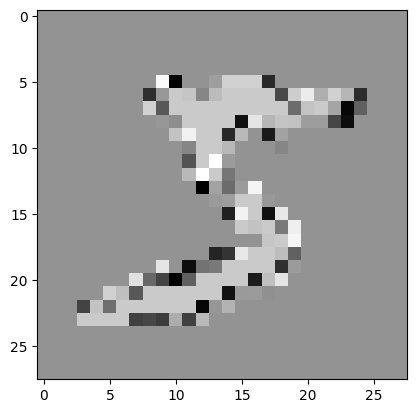

In [52]:
image = F.to_pil_image(x_0)
plt.imshow(image, cmap='gray')

## 1.4 Preparing the Data for Training

Earlier, we created a `trans` variable to convert an image to a tensor. [Transforms](https://pytorch.org/vision/stable/transforms.html) are a group of torchvision functions that can be used to transform a dataset.

In [123]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

In [124]:
for (x, y) in train_loader:
    print('x_train:', x.size(), 'type:', x.type())
    print('y_train:', y.size(), 'type:', y.type())
    break

x_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [56]:
for (x, y) in valid_loader:
    print('x_valid:', x.size(), 'type:', x.type())
    print('y_valid:', y.size(), 'type:', y.type())
    break

x_valid: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_valid: torch.Size([32]) type: torch.LongTensor


In [57]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## 1.5 Creating the Model

It's time to build the model! Neural networks are composed of layers where each layer performs a mathematical operation on the data it receives before passing it to the next layer. To start, we will create a "Hello World" level model made from 4 components:

1. A [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) used to convert n-dimensional data into a vector.
2. An input layer, the first layer of neurons
3. A hidden layer, another layor of neurons "hidden" between the input and output
4. An output layer, the last set of neurons which returns the final prediction from the model

More information about these layers is available in [this blog post](https://medium.com/@sarita_68521/basic-understanding-of-neural-network-structure-eecc8f149a23) by Sarita.

Let's create a `layers` variable to hold our list of layers.

In [ ]:
layers = []
layers

[]

### 1.5.1 Flattening the Image

When we looked at the shape of our data above, we saw the images had 3 dimensions: `C x H x W`. To flatten an image means to combine all of these images into 1 dimension. Let's say we have a tensor like the one below. Try running the code cell to see what it looks like before and after being flattened.

In [58]:
test_matrix = torch.tensor(
    [[1, 2, 3],
     [4, 5, 6],
     [7, 8, 9]]
)
print(test_matrix)
print(test_matrix.size())

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
torch.Size([3, 3])


In [59]:
# nn.Flatten()은 PyTorch의 신경망 모듈로, 입력 텐서를 평평하게 만드는 데 사용됨.
# 하지만 기본적으로 배치 차원(첫 번째 차원)은 평평하게 만들지 않음.
# 즉, nn.Flatten()은 입력 텐서의 배치 차원을 유지하면서 나머지 차원을 하나의 차원으로 평평하게 만듬
# test_matrix는 2차원 텐서이므로 배치 차원이 없습니다.
# 따라서 nn.Flatten()을 적용해도 텐서의 모양이 변경되지 않습니다.

nn.Flatten()(test_matrix)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [60]:
nn.Flatten()(test_matrix).size()

torch.Size([3, 3])

Nothing happened? That's because neural networks expect to recieve a batch of data. Currently, the Flatten layer sees three vectors as opposed to one 2d matrix. To fix this, we can "batch" our data by adding an extra pair of brackets. Since `test_matrix` is now a tensor, we can do that with the shorthand below. `None` adds a new dimension where `:` selects all the data in a tensor.

In [61]:
batch_test_matrix = test_matrix.unsqueeze(0)
batch_test_matrix, batch_test_matrix.size()

(tensor([[[1, 2, 3],
          [4, 5, 6],
          [7, 8, 9]]]),
 torch.Size([1, 3, 3]))

In [62]:
nn.Flatten()(batch_test_matrix)

tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [63]:
nn.Flatten()(batch_test_matrix).size()

torch.Size([1, 9])

In [ ]:
batch_test_matrix = test_matrix[None, :]  # 배열의 가장 앞쪽에 새로운 차원 추가, 3차원 배열로 변환
batch_test_matrix

tensor([[[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]])

In [ ]:
print(test_matrix.size())
print(batch_test_matrix.size())

torch.Size([3, 3])
torch.Size([1, 3, 3])


In [ ]:
nn.Flatten()(batch_test_matrix), nn.Flatten()(batch_test_matrix).size()

(tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9]]), torch.Size([1, 9]))

In [ ]:
# 배치 차원 추가
batch_test_matrix = test_matrix.unsqueeze(0)
print(batch_test_matrix, batch_test_matrix.size())

tensor([[[1, 2, 3],
         [4, 5, 6],
         [7, 8, 9]]]) torch.Size([1, 3, 3])


In [ ]:
# Flatten 적용
flattened_matrix = nn.Flatten()(batch_test_matrix)

print(flattened_matrix.shape)  # torch.Size([1, 9])
print(flattened_matrix)

torch.Size([1, 9])
tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9]])


Order matters! This is what happens when we do it the other way:

In [ ]:
# test_matrix[None, :]: 데이터 전체를 감싸는 새로운 차원을 추가
# test_matrix[:, None]: 데이터의 각 열을 새로운 차원으로 만들어 3차원으로 변형
# None: NumPy의 np.newaxis와 동일한 역할을 하며, 지정된 위치에 크기가 1인 새로운 축을 삽입.
# 이 경우 두 번째 차원(열 차원)에 새로운 축을 삽입

'''
[
    [
        [1, 2, 3]
    ],
    [
        [4, 5, 6]
    ],
    [
        [7, 8, 9]
    ]
]
'''
print(test_matrix[:, None], test_matrix[:, None].size())

tensor([[[1, 2, 3]],

        [[4, 5, 6]],

        [[7, 8, 9]]]) torch.Size([3, 1, 3])


In [ ]:
nn.Flatten()(test_matrix[:, None])

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [ ]:
nn.Flatten()(test_matrix[:, None]).size()

torch.Size([3, 3])

Now that we've gotten the hang of the `Flatten` layer, let's add it to our list of `layers`.

In [ ]:
layers = [
    nn.Flatten()
]
layers

[Flatten(start_dim=1, end_dim=-1)]

### 1.5.2 The Input Layer

Our first layer of neurons connects our flattened image to the rest of our model. To do that, we will use a [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layer. This layer will be *densely connected*, meaning that each neuron in it, and its weights, will affect every neuron in the next layer.

In order to create these weights, Pytorch needs to know the size of our inputs and how many neurons we want to create.
Since we've flattened our images, the size of our inputs is the number of channels, number of pixels vertically, and number of pixels horizontally multiplied together.

In [64]:
input_size = 1 * 28 * 28

Choosing the correct number of neurons is what puts the "science" in "data science" as it is a matter of capturing the statistical complexity of the dataset. For now, we will use `512` neurons. Try playing around with this value later to see how it affects training and to start developing a sense for what this number means.

We will learn more about activation functions later, but for now, we will use the [relu](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) activation function, which in short, will help our network to learn how to make more sophisticated guesses about data than if it were required to make guesses based on some strictly linear function.

In [65]:
layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
]
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU()]

### 1.5.3 The Hidden Layer

Now we will add an additional densely connected linear layer. We will cover why adding another set of neurons can help improve learning in the next lesson. Just like how the input layer needed to know the shape of the data that was being passed to it, a hidden layer's [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) needs to know the shape of the data being passed to it. Each neuron in the previous layer will compute one number, so the number of inputs into the hidden layer is the same as the number of neurons in the previous later.

In [66]:
layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
    nn.Linear(512, 512),  # Hidden
    nn.ReLU()  # Activation for hidden
]
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=512, bias=True),
 ReLU()]

### 1.5.4 The Output Layer

Finally, we will add an output layer. In this case, since the network is to make a guess about a single image belonging to 1 of 10 possible categories, there will be 10 outputs. Each output is assigned a neuron. The larger the value of the output neuron compared to the other neurons, the more the model predicts the input image belongs to the output neuron's assigned class.

We will not assign the `relu` function to the output layer. Instead, we will apply a `loss function` covered in the next section.

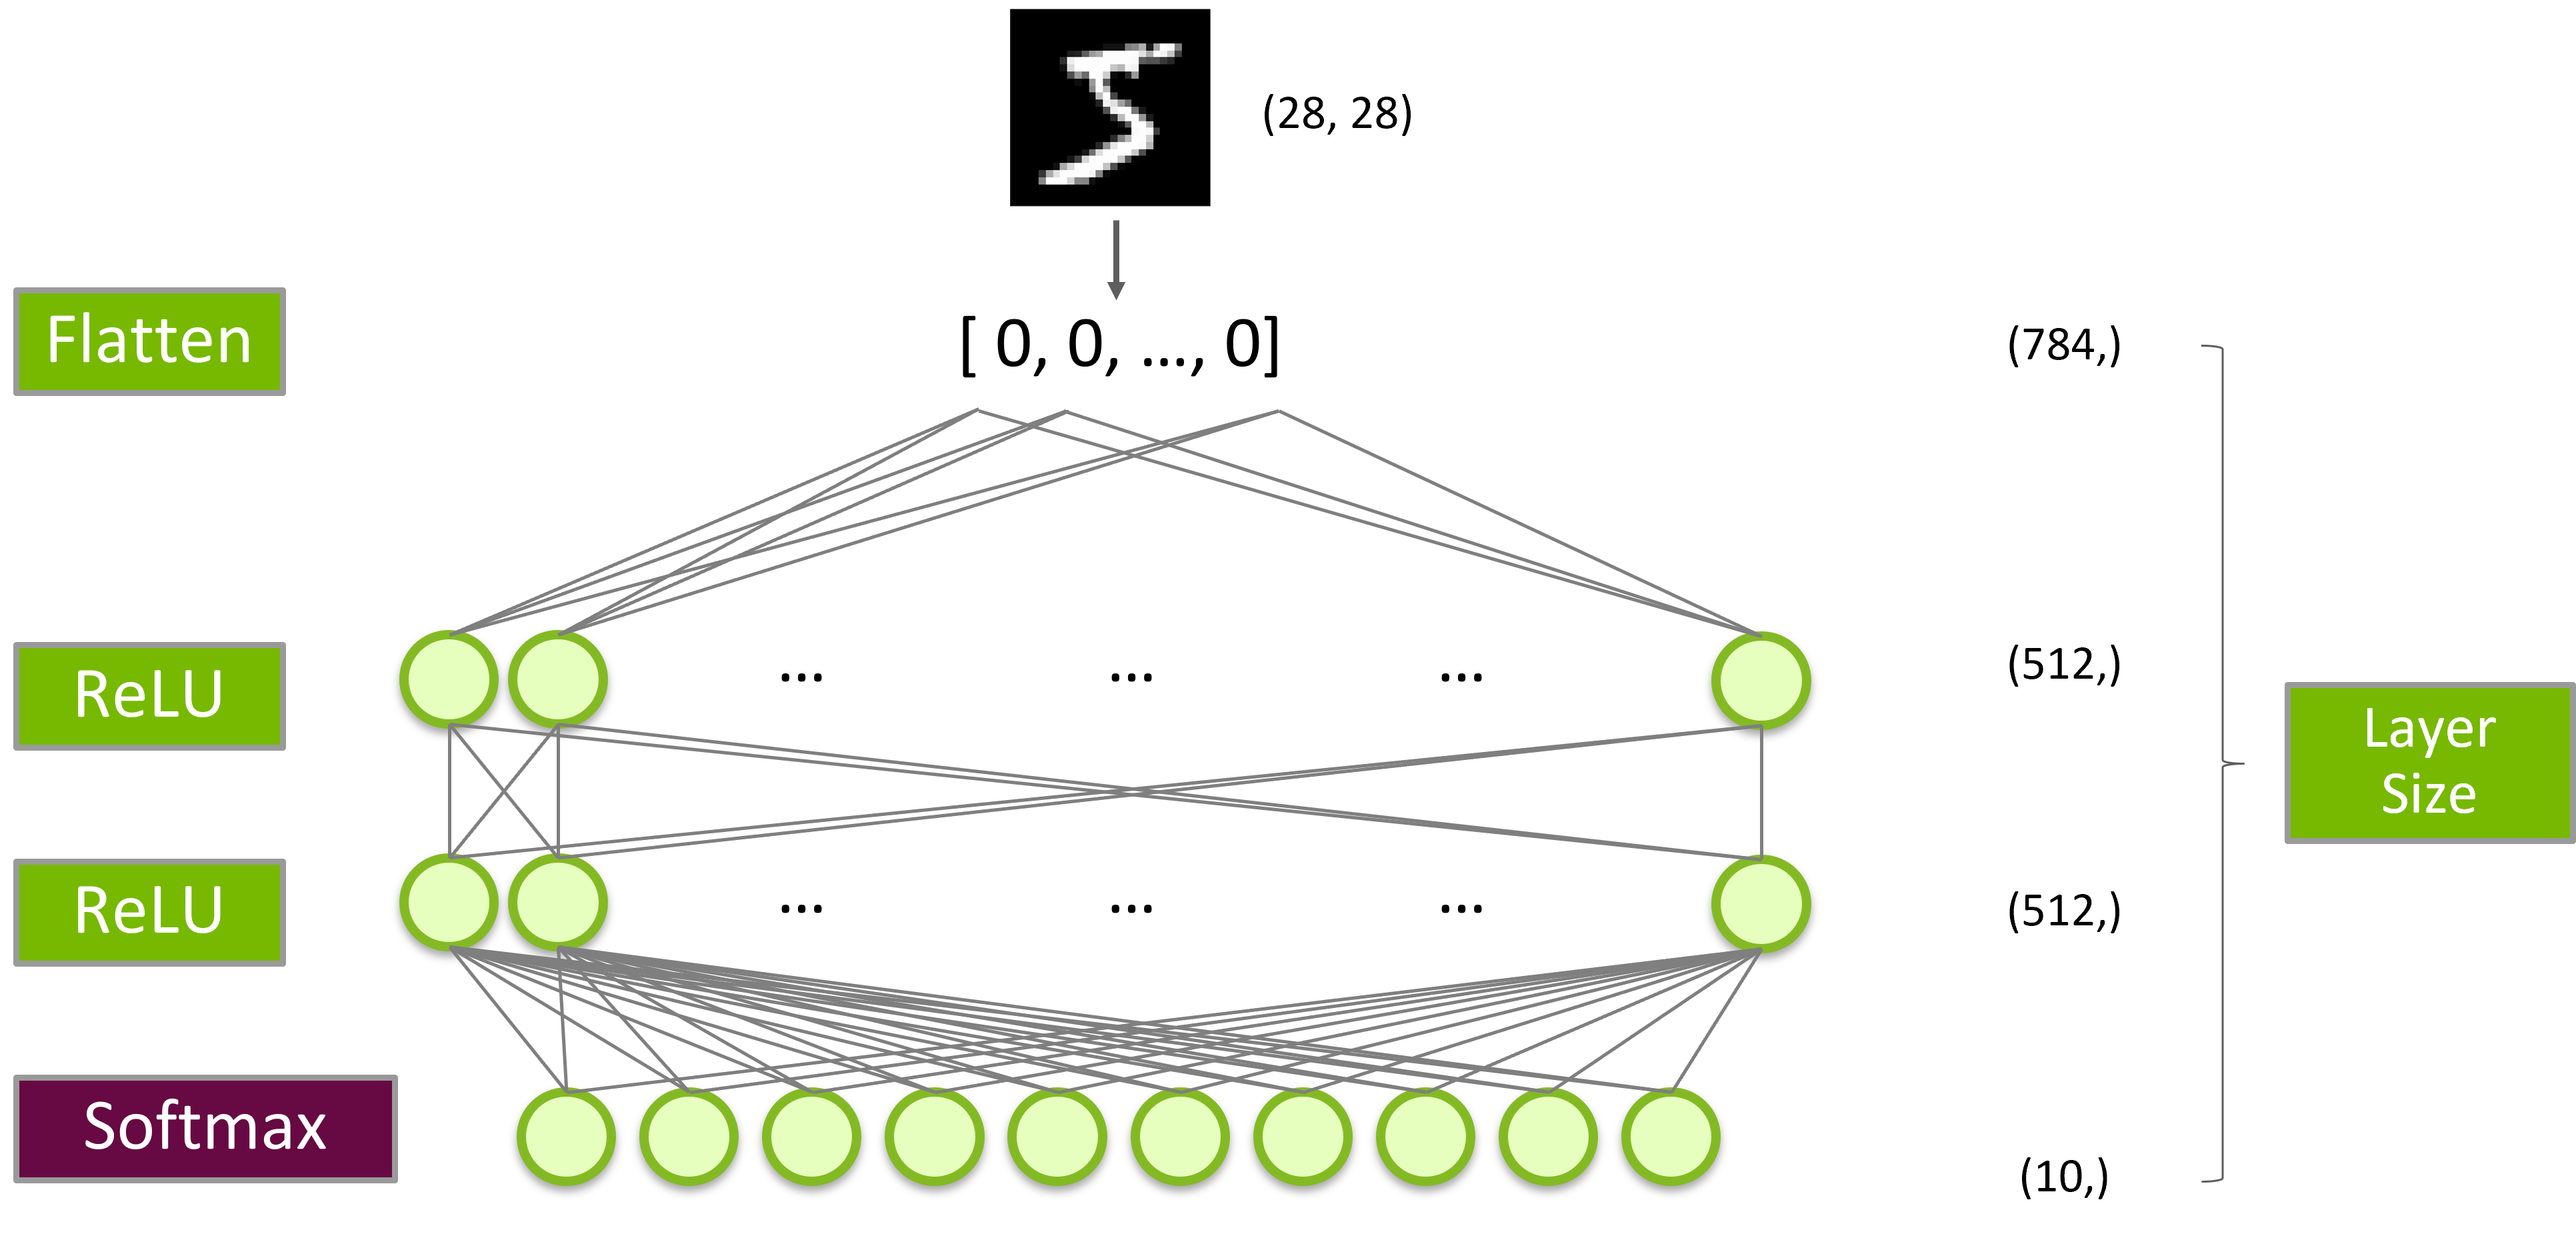

In [67]:
n_classes = 10

layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
    nn.Linear(512, 512),  # Hidden
    nn.ReLU(),  # Activation for hidden
    nn.Linear(512, n_classes)  # Output
]
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=10, bias=True)]

In [125]:
# nn.Flatten()은 이 3차원 이미지 텐서를 1차원 벡터로 펼쳐줍니다.
# Input image shape: (1, 28, 28)  →  Flatten → (1 × 28 × 28) = (784,)

n_classes = 10

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, 512),
    nn.ReLU(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Linear(512, n_classes)
)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

### 1.5.5 Compiling the Model

A [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) model expects a sequence of arguments, not a list, so we can use the [* operator](https://docs.python.org/3/reference/expressions.html#expression-lists) to unpack our list of layers into a sequence. We can print the model to verify these layers loaded correctly.

In [ ]:
model = nn.Sequential(*layers)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

Much like tensors, when the model is first initialized, it will be processed on a CPU. To have it process with a GPU, we can use `to(device)`.

In [126]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

To check which device a model is on, we can check which device the model parameters are on. Check out this [stack overflow](https://stackoverflow.com/questions/58926054/how-to-get-the-device-type-of-a-pytorch-module-conveniently) post for more information.

In [70]:
# 모델의 첫 번째 파라미터가 위치한 장치를 반환
next(model.parameters()).device

device(type='cuda', index=0)

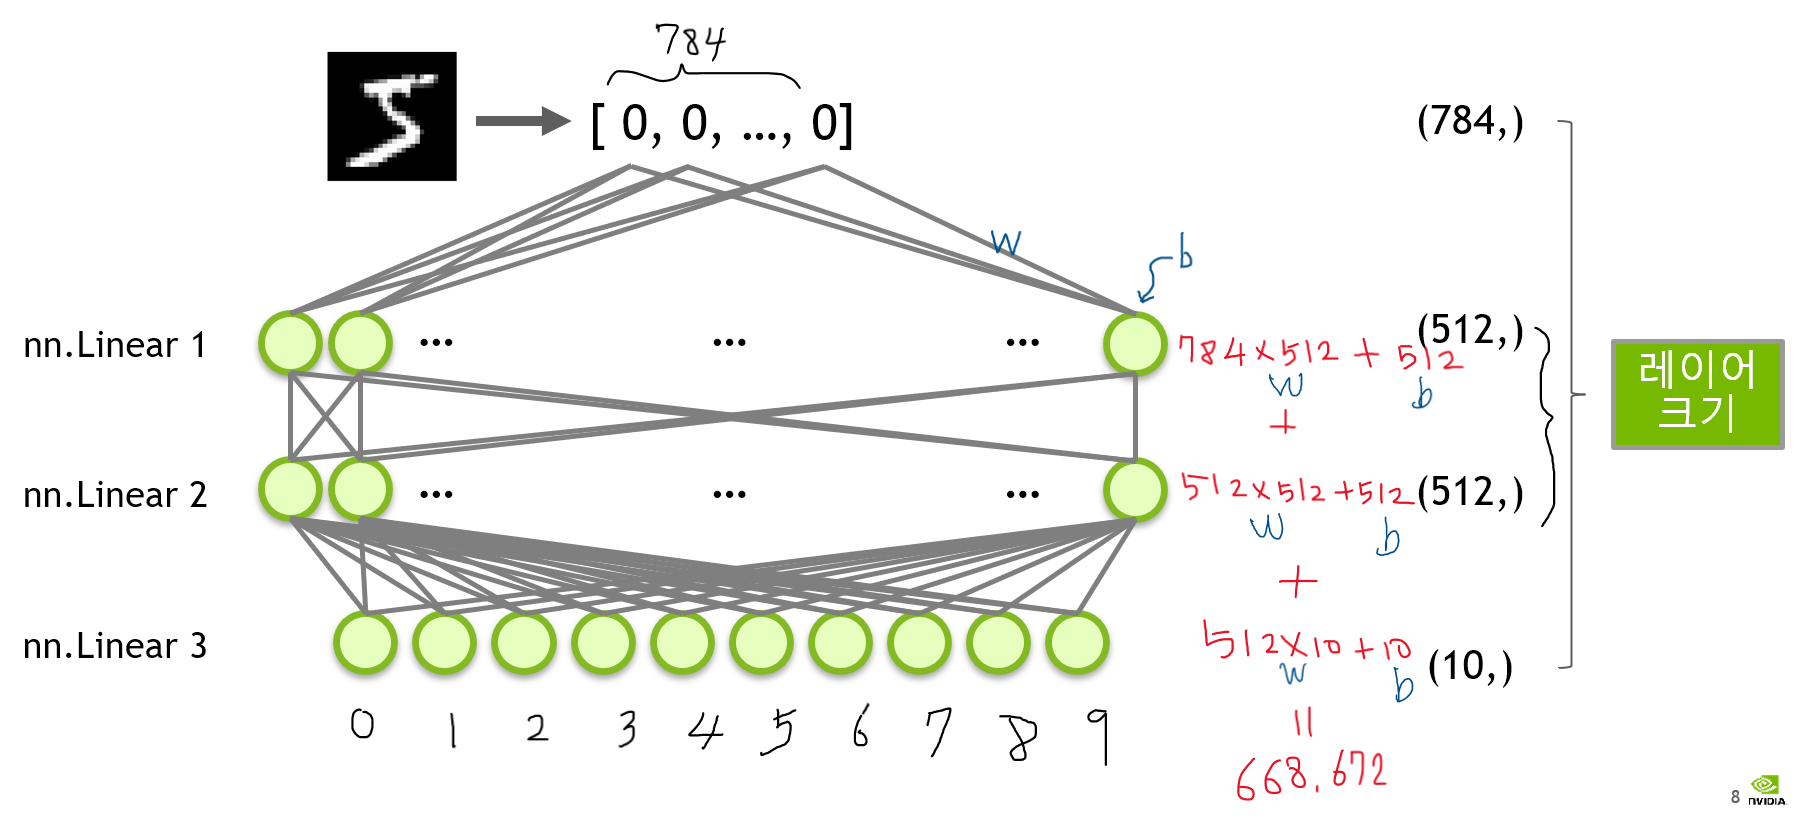

In [71]:
for param in model.parameters(): # 3개의 nn.Linear 계층의 weight, bias
    # print(param.shape, param)
    print(param.shape)

torch.Size([512, 784])
torch.Size([512])
torch.Size([512, 512])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


In [72]:
model.parameters

<bound method Module.parameters of Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)>

In [78]:
for name, param in model.named_parameters():
    print(f"Name: {name}")
    print(f"Shape: {param.shape}")
    print(f"Requires grad: {param.requires_grad}")
    print()


Name: 1.weight
Shape: torch.Size([512, 784])
Requires grad: True

Name: 1.bias
Shape: torch.Size([512])
Requires grad: True

Name: 3.weight
Shape: torch.Size([512, 512])
Requires grad: True

Name: 3.bias
Shape: torch.Size([512])
Requires grad: True

Name: 5.weight
Shape: torch.Size([10, 512])
Requires grad: True

Name: 5.bias
Shape: torch.Size([10])
Requires grad: True



## Parameters(Weight, bias) Calculation

In [ ]:
import torch

def calculate_total_weight_bias(model):
    """
    Calculates the total weight and bias for each layer in the model.

    Args:
        model: The PyTorch model.

    Returns:
        A dictionary where keys are layer names and values are tuples
        containing total weight and total bias for that layer.
    """

    total_params_per_layer = {}
    for name, param in model.named_parameters():
        layer_name = name.split('.')[0]  # Extract layer name from parameter name

        if layer_name not in total_params_per_layer:
            total_params_per_layer[layer_name] = {'weight': 0, 'bias': 0}

        if 'weight' in name:
            total_params_per_layer[layer_name]['weight'] += torch.numel(param)
        elif 'bias' in name:
            total_params_per_layer[layer_name]['bias'] += torch.numel(param)

    return total_params_per_layer

In [ ]:
total_params = calculate_total_weight_bias(model)

total_parameter = 0
for layer_name, params in total_params.items():
    print(f"Layer: {layer_name}, Total Weight: {params['weight']}, Total Bias: {params['bias']}")
    total_parameter += int(params['weight']) + int(params['bias'])

print("Total no. paramerets:", total_parameter)

Layer: 1, Total Weight: 401408, Total Bias: 512
Layer: 3, Total Weight: 262144, Total Bias: 512
Layer: 5, Total Weight: 5120, Total Bias: 10
Total no. paramerets: 669706


[PyTorch 2.0](https://pytorch.org/get-started/pytorch-2.0/) introduced the ability to compile a model for faster performance. Learn more about it [here](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html).

In [79]:
# torch.compile은 TorchDynamo, AOTAutograd, PrimTorch,
# 그리고 백엔드 컴파일러와 같은 다양한 기술을 사용하여 모델을 최적화

model = torch.compile(model)

## 1.6 Training the Model

Now that we have prepared training and validation data, and a model, it's time to train our model with our training data, and verify it with its validation data.

"Training a model with data" is often also called "fitting a model to data." Put another way, it highlights that the shape of the model changes over time to more accurately understand the data that it is being given.

### 1.6.1 Loss and Optimization

Just like how teachers grade students, we need to provide the model a function in which to grade its answers. This is called a `loss function`. We will use a type of loss function called [CrossEntropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) which is designed to grade if a model predicted the correct category from a group of categories.

In [127]:
loss_function = nn.CrossEntropyLoss()

Next, we select an `optimizer` for our model. If the `loss_function` provides a grade, the optimizer tells the model how to learn from this grade to do better next time.

In [128]:
optimizer = Adam(model.parameters())

### 1.6.2 Calculating Accuracy

While the results of the loss function are effective in helping our model learn, the values can be difficult to interpret for humans. This is why data scientists often include other metrics like accuracy.

In order to accurately calculate accuracy, we should compare the number of correct classifications compared to the total number of predictions made. Since we're showing data to the model in batches, our accuracy can be calculated along with these batches.

First, the total number of predictions is the same size as our dataset. Let's assign the size of our datasets to `N` where `n` is synonymous with the `batch size`.

In [129]:
train_N = len(train_loader.dataset)
valid_N = len(valid_loader.dataset)
print(train_N)
print(valid_N)

60000
10000


Next, we'll make a function to calculate the accuracy for each batch. The result is a fraction of the total accuracy, so we can add the accuracy of each batch together to get the total.

In [130]:
def get_batch_accuracy(output, y):
    pred = output.argmax(dim=1, keepdim=True)  # 예측값

    # view_as(pred)는 y 텐서를 pred 텐서와 동일한 모양으로 바꿈, item : Scalar 값 추출
    correct = pred.eq(y.view_as(pred)).sum().item()

    return correct

### 1.6.3 The Train Function

Here is where everything comes together. Below is the function we've defined to train our model based on the training data. We will walk through each line of code in more detail later, but take a moment to review how it is structured. Can you recognize the variables we created earlier?

In [ ]:
num_epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, num_epochs + 1):
    train_loss, val_loss = 0.0, 0.0
    train_correct, val_correct = 0.0, 0.0

    model.train() # prepare model for training
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
        
        # update running training loss
        train_loss += loss.item() * inputs.size(0)

        # training accuracy
        train_correct += get_batch_accuracy(output, labels)

    model.eval() # validate the model
    # val_correct = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = loss_function(output, labels)
            val_loss += loss.item() * inputs.size(0)

            # valid accuracy
            val_correct += get_batch_accuracy(output, labels)

    # calculate average loss over an epoch
    train_loss = train_loss/train_N
    val_loss = val_loss/valid_N 
    train_correct = train_correct/train_N
    val_correct = val_correct/valid_N

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_correct)
    val_accs.append(val_correct)

    print('Epoch: {}   Training Loss: {:.6f}    Valid Loss: {:.6f}    Training Accuracy: {:.3f}%    Valid Accuracy:{:.2f}%'.format(
        epoch, train_loss, val_loss, 100. * train_correct, 100. * val_correct))

Epoch: 1   Training Loss: 0.075265    Valid Loss: 0.091831    Training Accuracy: 97.737%    Valid Accuracy:97.68%
Epoch: 2   Training Loss: 0.068909    Valid Loss: 0.083831    Training Accuracy: 97.932%    Valid Accuracy:97.82%
Epoch: 3   Training Loss: 0.061025    Valid Loss: 0.083231    Training Accuracy: 98.172%    Valid Accuracy:97.66%
Epoch: 4   Training Loss: 0.054985    Valid Loss: 0.085750    Training Accuracy: 98.338%    Valid Accuracy:97.65%
Epoch: 5   Training Loss: 0.051114    Valid Loss: 0.077646    Training Accuracy: 98.423%    Valid Accuracy:98.06%
Epoch: 6   Training Loss: 0.049329    Valid Loss: 0.092819    Training Accuracy: 98.522%    Valid Accuracy:97.80%
Epoch: 7   Training Loss: 0.047701    Valid Loss: 0.086315    Training Accuracy: 98.627%    Valid Accuracy:97.82%
Epoch: 8   Training Loss: 0.043428    Valid Loss: 0.082395    Training Accuracy: 98.713%    Valid Accuracy:97.99%
Epoch: 9   Training Loss: 0.045788    Valid Loss: 0.088178    Training Accuracy: 98.653%

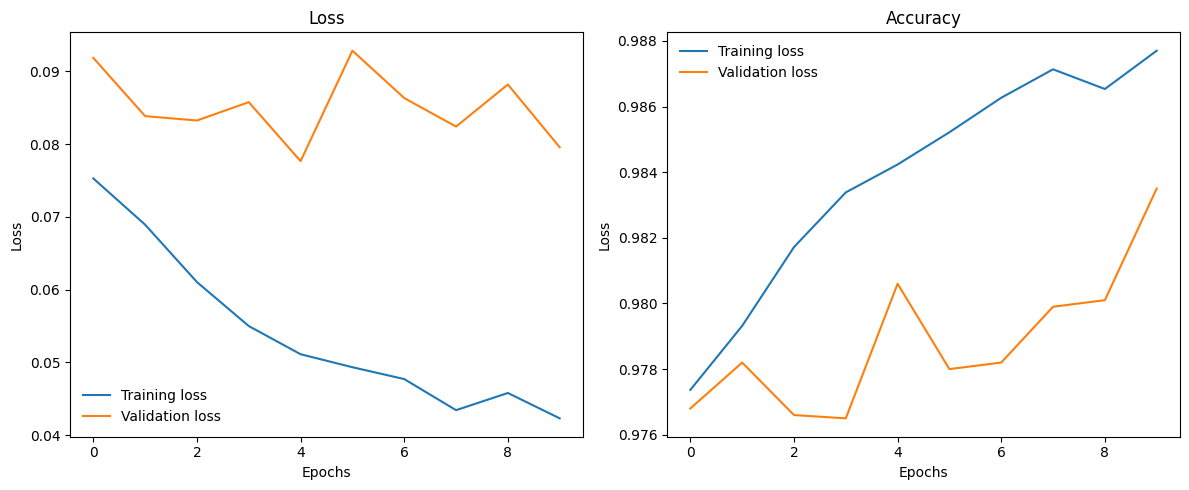

In [93]:
plt.figure(figsize=(12., 5.))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(train_losses, label='Training loss');
plt.plot(val_losses, label='Validation loss');
plt.xlabel("Epochs");
plt.ylabel("Loss");
plt.legend(frameon=False);

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(train_accs, label='Training loss');
plt.plot(val_accs, label='Validation loss');
plt.xlabel("Epochs");
plt.ylabel("Loss");
plt.legend(frameon=False);

plt.tight_layout()
plt.show()

## train(), validate() 함수로 구현

In [135]:
train_losses, train_accuracies = [],[]

def train():
    train_loss = 0.0
    train_correct = 0.0

    model.train()

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        # 새로운 배치(batch)로 학습을 진행하기 전에 이전 배치에서 계산된 기울기 값을 0으로 초기화
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        # # 배치별 오차를 누적하여 전체 오차를 계산
        train_loss += batch_loss.item() * x.size(0)
        # 배치별 정확도를 누적하여 전체 정확도를 계산
        train_correct += get_batch_accuracy(output, y)

    # calculate average loss over an epoch
    train_loss = train_loss/train_N
    train_acc = train_correct/train_N

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    print(f'Train - Loss: {train_loss:.3f}  Accuracy: {train_acc*100:.2f}%')

### 1.6.4 The Validate Function

Similarly, this is the code for validating the model with data it did not train on. Can you spot some differences with the `train` function?

In [136]:
valid_losses, valid_accuracies = [],[]

def validate():
    val_loss = 0.0
    val_correct = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            batch_loss = loss_function(output, y)
            val_loss += batch_loss.item() * x.size(0)

            val_correct += get_batch_accuracy(output, y)

    val_loss = val_loss/valid_N
    val_acc = val_correct/valid_N

    valid_losses.append(val_loss)
    valid_accuracies.append(val_acc)

    print(f'Valid - Loss: {val_loss:.3f}  Accuracy: {val_acc*100:.2f}%')

### 1.6.5 The Training Loop

To see how the model is progressing, we will alternated between training and validation. Just like how it might take a student a few times going through their deck of flash cards to learn all the concepts, the model will go through the training data multiple times to get a better and better understanding.

An `epoch` is one complete pass through the entire dataset. Let's train and validate the model for 5 `epochs` to see how it learns.

In [137]:
epochs = 20

for epoch in range(epochs):
    print(f'Epoch: {epoch+1}/{epochs}')
    train()
    validate()

Epoch: 1/20
Train - Loss: 0.085  Accuracy: 97.33%
Valid - Loss: 0.078  Accuracy: 97.61%
Epoch: 2/20
Train - Loss: 0.073  Accuracy: 97.74%
Valid - Loss: 0.076  Accuracy: 97.92%
Epoch: 3/20
Train - Loss: 0.069  Accuracy: 97.89%
Valid - Loss: 0.064  Accuracy: 98.27%
Epoch: 4/20
Train - Loss: 0.062  Accuracy: 98.13%
Valid - Loss: 0.084  Accuracy: 97.70%
Epoch: 5/20
Train - Loss: 0.054  Accuracy: 98.30%
Valid - Loss: 0.074  Accuracy: 98.02%
Epoch: 6/20
Train - Loss: 0.052  Accuracy: 98.43%
Valid - Loss: 0.082  Accuracy: 97.74%
Epoch: 7/20
Train - Loss: 0.048  Accuracy: 98.52%
Valid - Loss: 0.084  Accuracy: 97.94%
Epoch: 8/20
Train - Loss: 0.046  Accuracy: 98.59%
Valid - Loss: 0.101  Accuracy: 97.41%
Epoch: 9/20
Train - Loss: 0.045  Accuracy: 98.66%
Valid - Loss: 0.093  Accuracy: 97.76%
Epoch: 10/20
Train - Loss: 0.044  Accuracy: 98.67%
Valid - Loss: 0.096  Accuracy: 97.97%
Epoch: 11/20
Train - Loss: 0.041  Accuracy: 98.78%
Valid - Loss: 0.097  Accuracy: 97.66%
Epoch: 12/20
Train - Loss: 0.0

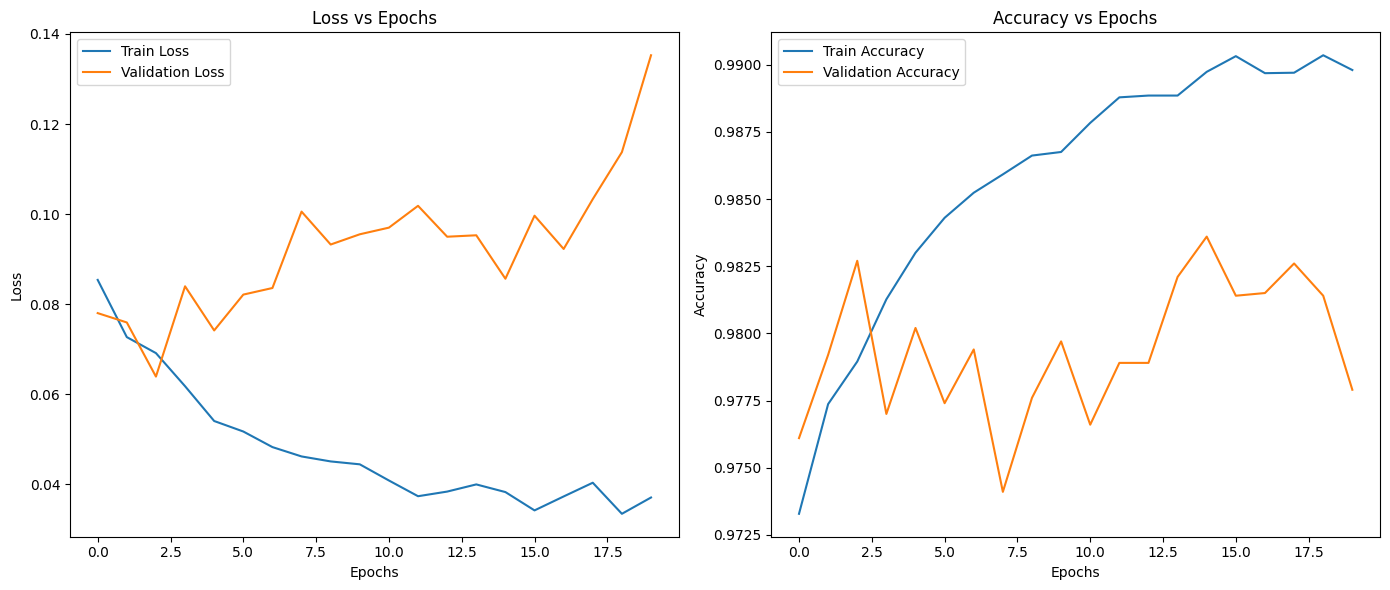

In [138]:
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

We're already close to 100%! Let's see if it's true by testing it on our original sample. We can use our model like a function:

In [139]:
prediction = model(x_0_gpu)
prediction

tensor([[-61.7219, -32.3736, -37.4019,  -3.1213, -53.7990,  19.4588, -32.5366,
         -36.6629, -21.4767, -11.1525]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

There should be ten numbers, each corresponding to a different output neuron. Thanks to how the data is structured, the index of each number matches the corresponding handwritten number. The 0th index is a prediction for a handwritten 0, the 1st index is a prediction for a handwritten 1, and so on.

We can use the `argmax` function to find the index of the highest value.

In [140]:
prediction.argmax(dim=1, keepdim=True)

tensor([[5]], device='cuda:0')

Did it get it right?

In [141]:
y_0

5

In [142]:
print(x_0_gpu.shape)
print(x_0_gpu.squeeze(0).shape)

torch.Size([1, 28, 28])
torch.Size([28, 28])


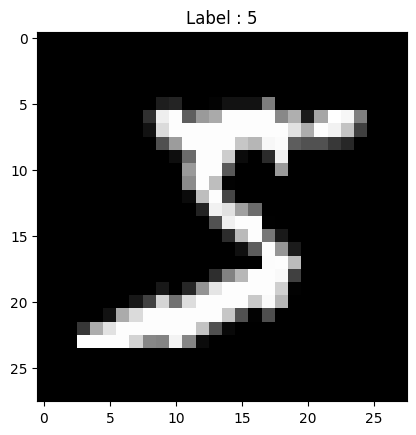

In [ ]:
plt.title("Label : " + str(y_0))
plt.imshow(x_0_gpu.cpu().squeeze(0), cmap='gray')
plt.show()

## 1.7 Summary

The model did quite well! The accuracy quickly reached close to 100%, as did the validation accuracy. We now have a model that can be used to accurately detect and classify hand-written images.

The next step would be to use this model to classify new not-yet-seen handwritten images. This is called [inference](https://blogs.nvidia.com/blog/2016/08/22/difference-deep-learning-training-inference-ai/). We'll explore the process of inference in a later exercise.

It's worth taking a moment to appreciate what we've done here. Historically, the expert systems that were built to do this kind of task were extremely complicated, and people spent their careers building them (check out the references on the [official MNIST page](http://yann.lecun.com/exdb/mnist/) and the years milestones were reached).

MNIST is not only useful for its historical influence on Computer Vision, but it's also a great [benchmark](http://www.cs.toronto.edu/~serailhydra/publications/tbd-iiswc18.pdf) and debugging tool. Having trouble getting a fancy new machine learning architecture working? Check it against MNIST. If it can't learn on this dataset, chances are it won't learn on more complicated images and datasets.

### 1.7.1 Clear the Memory

Before moving on, please execute the following cell to clear up the GPU memory. This is required to move on to the next notebook.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

### 1.7.2 Next

In this section you learned how to build and train a simple neural network for image classification. In the next section, you will be asked to build your own neural network and perform data preparation to solve a different image classification problem.